# Backpropagation

### Take-away messages:

* Dimensions of the weight matrix for layer N are (1 + # of neurons in layer N, # of neurons in layer N+1).
* If something in your code isn't working, try looking at dimensions of your variables first.
* Backprop works on the same principle as gradient descent. You can think of neural networks as a lot of interconnected logistic regressions. 
* Log loss is a good loss function because it has a high value for a poor prediction and low value for good prediction (and it's also mathematically neat because it's easy to differentiate).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# number of neurons in the hidden layer
n_neurons = 2

In [ ]:
# STEP 1: Create training data
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=50, noise=0.2, random_state=42)

In [ ]:
# STEP 2: Take a look at the data
plt.scatter(X[:,0], X[:,1], c=y)

In [ ]:
# STEP 3: add a bias (parameter b) column to X
def add_bias(X):
    return np.hstack([X, np.ones((X.shape[0], 1))])

In [ ]:
X = add_bias(X)

In [ ]:
# STEP 4: calculate the sigmoid activation function
def sigmoid(x):
    return 1/(1+np.exp(-x))

a = np.array([-10.0, -1.0, 0.0, 1.0, 10.0])
expected = np.array([0.0, 0.27, 0.5, 0.73, 1.0])
assert np.all(sigmoid(a).round(2) == expected)

In [ ]:
# STEP 5: initialize the weights
w = []
w.append(np.random.randn(3, n_neurons)) # first layer
w.append(np.random.randn(n_neurons+1, 1)) # second layer

In [ ]:
def feed_forward(X, weights):

    ''' 0. add bias column to X 
    turning X from shape of (50, 2)
    to shape (50, 3)'''
#    X = add_bias(X)
    
    ''' 1. calculate the dot product of X
    (shape of (50,3))
    and the weights of the first layer
    (shape of (3, 3))
    this results in an output shape of (50, 3)'''
    step1 = np.dot(X, weights[0])

    ''' 2. apply the sigmoid function on the result
    (applying the sigmoid function on a 50x3 matrix outputs the same shape).
    '''
    step2 = sigmoid(step1)

    ''' 3. append an extra 1 for the bias to the result
    (this results in a 50x4 matrix)'''
    step3 = add_bias(step2)

    ''' 4. calculate the dot product of X (from step 3)
    (shape of (50, 4))
    and the weights of the second layer
    (shape of (4, 1)). This results in an output shape of (50, 1)'''
    step4 = np.dot(step3, weights[1])

    ''' 5. apply the sigmoid function on the result
    (preserves the shape)'''
    step5 = sigmoid(step4)
    
    ''' STEP 6. return all intermediate results'''
    return step2, step5

In [ ]:
out1, out2 = feed_forward(X, w)

assert out1.shape == (50, n_neurons)
assert out2.shape == (50, 1)

In [ ]:
Xref = np.array([[1.0, 2.0, 1.0]])
whidden = np.array([[1.0, 2.0, 0.0],
                 [-1.0, -2.0, 0.0]
                    ]).T
wout = np.array([[1.0, -1.0, 0.5]]).T

out1, out2 = feed_forward(Xref, [whidden, wout])
assert np.all(out1.round(2) == np.array([[0.99, 0.01]]))
assert np.all(out2.round(2) == np.array([[0.82]]))

### Backprop(agation)

* Gradient descent
$$ w_{new} = w_{old} - LR \cdot \nabla L(w) $$
* In feed-forward step, stuff happens from left to right. Your vector of features gets multipled by your weights, summed up, passed through the activation function, multiplied by the weights in the next layer, summed up, etc.
* In the general case, the value in the output layer will be different from the value that our neural network calculated (ytrue=0, vs. ypred=0.77). We use this discrepancy to adjust our weights so that they start giving better predictions.
* This repeated right-to-left step is called _backpropagation_.

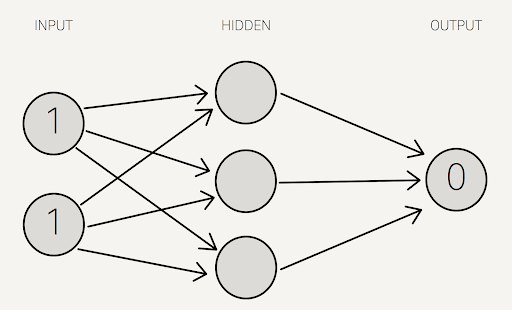

Adapted from _Neural Networks with Keras Cookbook_ by V Kishore Ayyadevara

* From the course materials

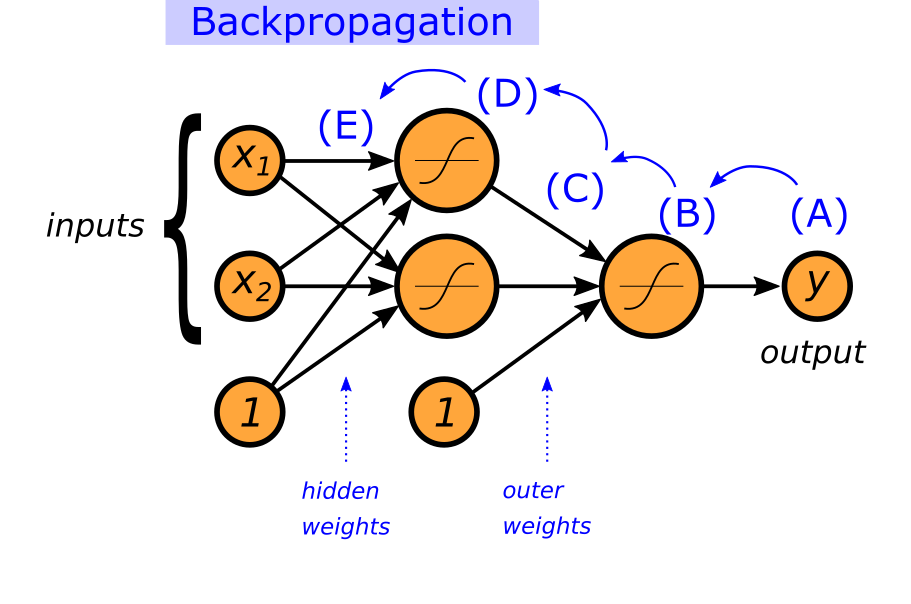

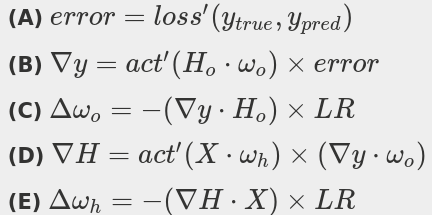

**Let's talk about the loss function!**

* Here we'll use log loss as a loss function:
$$ loss = -(y_{true} log(y_{pred}) + (1-y_{true}) log(1-y_{pred})) $$

* If your label is 1 ($y_{true}=1$): $ loss = -log(y_{pred}) $
    * If your prediction is close to 0, our model isn't performing very well. Minus of log of a number close to 0 is a "large" number.
    * If your prediction is close to 1, our model is doing really well. Loss function in that case is very close to zero.
* If your label is 0 ($y_{true}=0$): $ loss = -log(1-y_{pred}) $ 
    * If your prediction is close to 1, model isn't doing well. Loss function is minus log of a number close to zero, so it is "big".
    * If your prediction is close to 0, model is doing well. Loss function is close to zero, as a minus of log of a number close to 1.

In [ ]:
# STEP 2: calculate the log-loss
def log_loss(ytrue, ypred):
    loss = -(ytrue*np.log(ypred) + (1-ytrue)*np.log(1-ypred))
    return loss

ytrue = np.array([0.0, 0.0, 1.0, 1.0])
ypred = np.array([0.01, 0.99, 0.01, 0.99])
expected = np.array([0.01, 4.61, 4.61, 0.01])
assert np.all(log_loss(ytrue, ypred).round(2) == expected)

In [ ]:
# STEP 2a: calculate the log loss derivative
def log_loss_deriv(ytrue, ypred):
    return -(ytrue/ypred - (1-ytrue)/(1-ypred))

In [ ]:
# STEP 2b: calculate the sigmoid derivative
def sigmoid_deriv(X):
    return sigmoid(X) * (1-sigmoid(X))

In [ ]:
# STEP 3: calculate initial loss
out1, out2 = feed_forward(X, w)

In [ ]:
ytrue = y.reshape(-1, 1)

In [ ]:
loss = log_loss(ytrue, out2)

In [ ]:
[print(x, y, z) for (x, y, z) in zip(ytrue, out2, loss)]

In [ ]:
# STEP 4: write backpropagation function
def backprop(weights,
             output1,
             output2,
             ytrue,
             X_input,
             LR):

    wH = weights[0]
    wO = weights[1]

    '''EQUATION A:'''
    error = log_loss_deriv(ytrue, output2)
    
    '''EQUATION B:'''
    #don't forget the bias!
    hidden_out_with_bias = add_bias(output1)
    #derivative of the sigmoid function with respect to the
    #hidden output * weights
    sig_deriv_1 = sigmoid_deriv(hidden_out_with_bias.dot(wO))
    y_grad = sig_deriv_1 * error

    '''EQUATION C:'''
    delta_wO = -np.dot(y_grad.T, hidden_out_with_bias) * LR

    #and finally, old weights + delta weights -> new weights!
    wO_new = wO + delta_wO.T

    '''EQUATION D:'''
    sig_deriv_2 = sigmoid_deriv(X_input.dot(wH))
    #exclude the bias (last column) of the outer weights,
    #since it is not backpropagated!
    H_grad = sig_deriv_2 * np.dot(y_grad , wO[:-1].T)
    
    '''EQUATION E:'''
    delta_wH = -np.dot(H_grad.T, X_input) * LR
    #old weights + delta weights -> new weights!
    wH_new = wH + delta_wH.T
    
    # new hidden weights, new output weights
    return wH_new, wO_new

In [ ]:
# STEP 5: run the backpropagation algorithm
# setup

# increase the number of neurons to see how the performance 
# of your neural network changes
LR = 0.01
n_neurons = 5
X, y = make_moons(n_samples=200, noise=0.2, random_state=42)
X = add_bias(X)
y = y.reshape(-1, 1)
weights = [
   np.random.randn(3, n_neurons),
   np.random.randn(n_neurons+1, 1)
]
X
# train
LOSS_VEC = []

# change the value for learning rate in backprop to see how your model performance changes
for i in range(1000):
    out1, out2 = feed_forward(X, weights)
    LOSS_VEC.append(log_loss(y, out2).sum())
    new_weights = backprop(weights, out1, out2, y, X, LR)
    weights = new_weights

In [ ]:
plt.plot(LOSS_VEC)

### Plot the decision boundary

In [ ]:
# create a grid of values
x = np.linspace(-3, 3, 200)
X_vis = np.array([(x1, x2) for x1 in x for x2 in x])
# add the bias column
X_vis = add_bias(X_vis)

# calculate the (random) predictions
_, y_pred = feed_forward(X_vis, weights)

In [ ]:
# reshape the predictions for visualization
Z = y_pred.reshape((len(x), len(x)), order='F')

In [ ]:
# draw a contour plot
fig,ax=plt.subplots(1,1)
cp = ax.contourf(x, x, Z, alpha=0.8, cmap='coolwarm')
ax.contour(x, x, Z, levels=[0.5])
fig.colorbar(cp) # Add a colorbar to a plot

# draw the original data
X, y = make_moons(n_samples=200, noise=0.1, random_state=42)
ax.scatter(X[:,0], X[:,1], c=y, cmap='coolwarm')